# Visualize Explanations

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as image
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from graphxai.datasets import ShapeGGen
from graphxai.explainers import GNNExplainer, GradExplainer, GuidedBP, GraphLIME, IntegratedGradExplainer
from graphxai.explainers import CAM, GradCAM, GNN_LRP, PGMExplainer, PGExplainer, RandomExplainer, SubgraphX
import random

#### Before moving forward, run `prepare_graphxai_data.py` to generate an EPI dataset (GM12878) in Planetoid form!

In [6]:
dataset = Planetoid(root='GM12878', name='Cora')
print(dataset.data)

Data(x=[6378, 1024], edge_index=[2, 124322], y=[6378], train_mask=[6378], val_mask=[6378], test_mask=[6378])


In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    x, edge_index = dataset.x, dataset.edge_index
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [9]:
model.eval()
pred = model(data.x, data.edge_index).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.6301


In [8]:
def nodes_with_label(self, label = 0, mask = None):
    '''
    Get all nodes that are a certain label
    Args:
        label (int, optional): Label for which to find nodes.
            (:default: :obj:`0`)
    Returns:
        torch.Tensor: Indices of nodes that are of the label
    '''
    if mask is not None:
        return ((self.y == label) & (mask)).nonzero(as_tuple=True)[0]
    return (self.y == label).nonzero(as_tuple=True)[0]


def choose_node(self, label = None, split = None, seed=42):
    '''
    Chooses random nodes in the graph. Has support for multiple logical
        indexing.

    Args:
        label (int, optional): Label for which to find node.
            (:default: :obj:`0`)
        split (string, optional): Masking type for which to find node.
            (:default: :obj:`0`)

    Returns:
        Tuple[int, Explanation]
            int: Node index found
            Explanation: Explanation corresponding to that node index
    '''
    split = split.lower() if split is not None else None

    if split == 'validation' or split == 'valid' or split == 'val':
        split = 'val'

    map_to_mask = {
        'train': self.train_mask,
        #'val': self.valid_mask,
        'test': self.test_mask,
    }

    # Get mask based on provided string:
    mask = None if split is None else map_to_mask[split]

    if label is None:
        to_choose = torch.arange(end = self.num_nodes)
    else:
        to_choose = nodes_with_label(self, label = label, mask = mask)

    assert_fmt = 'Could not find a node in {} with inshape={}, label={}'
    assert to_choose.nelement() > 0, assert_fmt.format(self.name, inshape, label)
    random.seed(seed)
    node_idx = random.choice(to_choose).item()
    return node_idx, None #, self.explanations[node_idx]

In [11]:
# Embedding layer name is final GNN embedding layer in the model
pgex = PGExplainer(model, emb_layer_name = 'conv2', max_epochs = 10, lr = 0.1)

# Required to first train PGExplainer on the dataset:
# Feed in entire data, the internal model uses the data's train mask
pgex.train_explanation_model(data)

# No training with Integrated Gradients, just run the model:
igex = IntegratedGradExplainer(model, criterion=criterion)

816it [00:02, 332.59it/s]
816it [00:04, 191.56it/s]
816it [00:04, 191.08it/s]
816it [00:04, 189.24it/s]
816it [00:04, 194.38it/s]
816it [00:04, 186.61it/s]
816it [00:05, 160.75it/s]
816it [00:04, 168.85it/s]
816it [00:04, 169.37it/s]
816it [00:04, 165.32it/s]
816it [00:04, 174.94it/s]

training time is 45.765s


# ENHANCER (LABEL=0)

1192


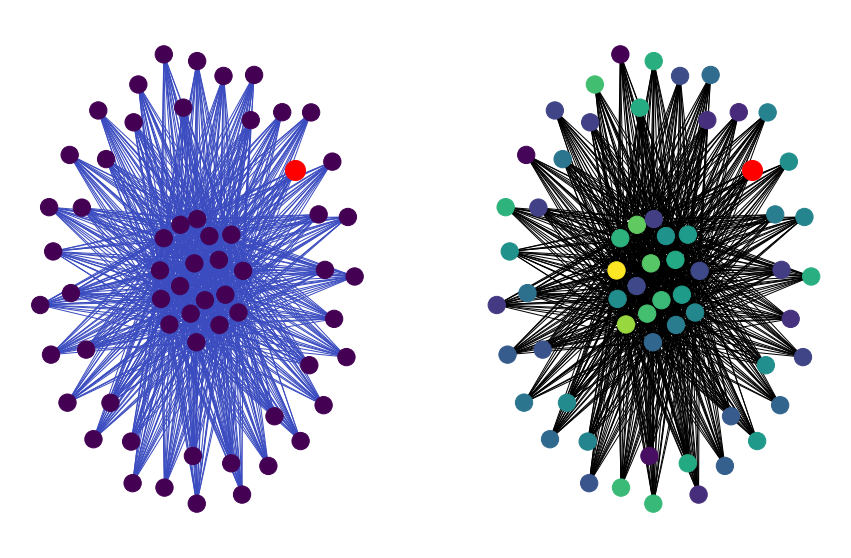

In [12]:
# Sample a random node for visualization. Also returns a ground truth explanation:
# [1,0] -> label = 0 (enhancer class)
# [0,1] -> label = 1 (promoter class)
node_idx, gt_exp = choose_node(data, label=0, split='test', seed=42) # choose a random enhancer from test set
print(node_idx)

# Sample a random node for visualization. Also returns a ground truth explanation:
# [1,0] -> label = 0 (enhancer class)
# [0,1] -> label = 1 (promoter class)
node_idx, gt_exp = choose_node(data, label=0, split='test') # choose a random enhancer from test set

pgex_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

#fig, ax = plt.subplots(1,3, figsize = (10, 8))
# Ground-truth explanations always provided as a list. In ShapeGGen, we use the first
#   element since it produces unique explanations. 
#gt_exp[0].visualize_node(num_hops = 3, graph_data = data, ax = ax[0])
#pgex_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[1])
#ig_exp.visualize_node(num_hops = 3, graph_data = data, ax = ax[2])

fig, ax = plt.subplots(1,2, figsize = (15, 10))
pgex_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[0])
ig_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[1])

# PROMOTER (LABEL=1)

1130


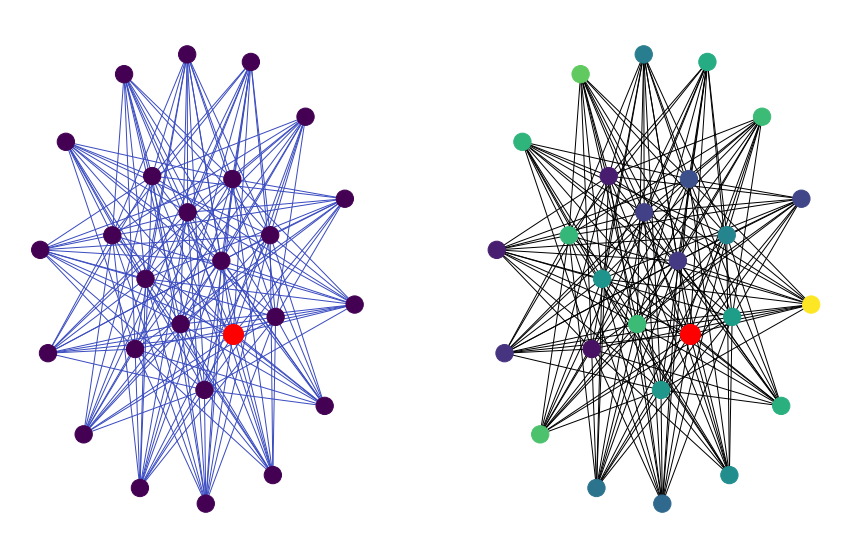

In [13]:
# Sample a random node for visualization. Also returns a ground truth explanation:
# [1,0] -> label = 0 (enhancer class)
# [0,1] -> label = 1 (promoter class)
node_idx, gt_exp = choose_node(data, label=1, split='test', seed=42) # choose a random promoter from test set
print(node_idx)

# Get explanations from both IG and PGEx:
pgex_exp = pgex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index)
ig_exp = igex.get_explanation_node(node_idx = node_idx, x = data.x, edge_index = data.edge_index, y = data.y)

fig, ax = plt.subplots(1,2, figsize = (15, 10))
pgex_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[0])
ig_exp.visualize_node(num_hops = 2, graph_data = data, ax = ax[1])

Now we move to evaluate the explanations. `GraphXAI` provides fairness, faithfulness, stability, and accuracy metrics. Here we only use accuracy as it's more directly interpretable with respect to our above plot.

In [14]:
# from graphxai.metrics import graph_exp_acc

# Accuracy for each method:
# pg_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = pgex_exp)

# pg_faith = graph_exp_faith(generated_exp = pgex_exp, data, pgex, 0.25)

# Threshold is the lower bound for which we consider a node to be "positive". 
# Here we take 80% of the maximum value for the node importance of integrated gradients.
# ig_acc = graph_exp_acc(gt_exp = gt_exp[0], generated_exp = ig_exp, 
#                        threshold = ig_exp.node_imp.max().item() * 0.8)

# print('PGExplainer Accuracy: {:.4f}'.format(pg_acc))
# print('Integrated Gradients Accuracy: {:.4f}'.format(ig_acc))

We see that both of the explainers are able to capture some of the ground-truth explanation, but not all of it. PGExplainer gets about half of the correct nodes in the ground-truth explanation.

In [15]:
def get_exp_method(method, data, model, criterion, node_idx, pred_class, n_hops = 2):
    method = method.lower()
    if method=='gnnex':
        exp_method = GNNExplainer(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='grad':
        exp_method = GradExplainer(model, criterion = criterion)
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='cam':
        exp_method = CAM(model, activation = lambda x: torch.argmax(x, dim=1))
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='gcam':
        exp_method = GradCAM(model, criterion = criterion)
        forward_kwargs={'x':data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device),
                        'average_variant': [True]}
    elif method=='gbp':
        exp_method = GuidedBP(model, criterion = criterion)
        forward_kwargs={'x': data.x.to(device),
                        'y': data.y.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='glime':
        exp_method = GraphLIME(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='ig':
        exp_method = IntegratedGradExplainer(model, criterion = criterion)
        forward_kwargs = {'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'node_idx': int(node_idx),
                        'label': pred_class}
    elif method=='glrp':
        exp_method = GNN_LRP(model)
        forward_kwargs={'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'node_idx': node_idx,
                        'label': pred_class,
                        'edge_aggregator':torch.sum}
    elif method=='pgmex':
        exp_method=PGMExplainer(model, explain_graph=False, p_threshold=0.1)
        forward_kwargs={'node_idx': node_idx,
                        'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'top_k_nodes': 10}
    elif method=='pgex':
        exp_method=pgex
        forward_kwargs={'node_idx': node_idx,
                        'x': data.x.to(device),
                        'edge_index': data.edge_index.to(device),
                        'label': pred_class}
    elif method=='rand':
        exp_method = RandomExplainer(model)
        forward_kwargs={'x': data.x.to(device),
                        'node_idx': int(node_idx),
                        'edge_index': data.edge_index.to(device)}
    elif method=='subx':
        exp_method = SubgraphX(model, reward_method = 'gnn_score', num_hops = n_hops, rollout=5)
        forward_kwargs={'node_idx': int(node_idx),
                        'x': data.x.to(device),
                        'y': data.y.to(device),
                        'edge_index': data.edge_index.to(device),
                        'label': pred_class,
                        'max_nodes': 10}
    else:
        OSError('Invalid argument!!')
    return exp_method, forward_kwargs

In [16]:
def visualize_all_explanations(data, label, node_idx, n_hops=2):

    exp_list = ['gnnex', 'gcam', 'pgex', 'pgmex',
            'rand', 'gbp', 'cam', 'grad', 'subx']

    exp_name_map = {
        'gnnex': 'GNNExplainer',
        'gcam': 'Grad-CAM',
        'subx': 'SubgraphX',
        'rand': 'Random',
        'pgmex': 'PGMExplainer',
        'pgex': 'PGExplainer',
        'gbp': 'Guided Backprop',
        'cam': 'CAM',
        'grad': 'Gradient' 
    }

    # Number: 10

    fig, ax = plt.subplots(2, 5, tight_layout = True, figsize=(20, 15))

    inds = [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4),
            (1, 0), (1, 1), (1, 2), (1, 3)]

    # gt_exp[0].visualize_node(num_hops = n_hops, additional_hops = 0, graph_data = data, ax = ax[0,0])
    # ax[0,0].set_title('Ground Truth', fontsize = 20, fontweight = 'semibold')

    for i in range(0, 9):
        E = exp_list[i]
        print(f'E = {E}')
        EXP, fwargs = get_exp_method(
            method = E,
            model = model,
            data = data,
            criterion = criterion,
            node_idx = node_idx,
            pred_class = pred.clone(),
            n_hops = n_hops
            )

        exp = EXP.get_explanation_node(**fwargs)

        exp.visualize_node(num_hops = n_hops, additional_hops = 0, graph_data = data, 
                           ax = ax[inds[i][0], inds[i][1]], norm_imps = False)

        ax[inds[i][0], inds[i][1]].set_title(exp_name_map[E], fontsize = 20, fontweight = 'semibold')

    file = 'importance.png'
    imp = image.imread(file)
    ax[1,4].imshow(imp)
    plt.axis('off')
    plt.savefig('vis_img_{}_{}.pdf'.format(label, node_idx), format = 'pdf', dpi = 150)

# ENHANCER (LABEL=0)

6277
E = gnnex
E = gcam
E = pgex
E = pgmex


  0%|                                   | 1/1000000 [00:00<104:17:52,  2.66it/s]


E = rand
E = gbp
E = cam
E = grad
E = subx


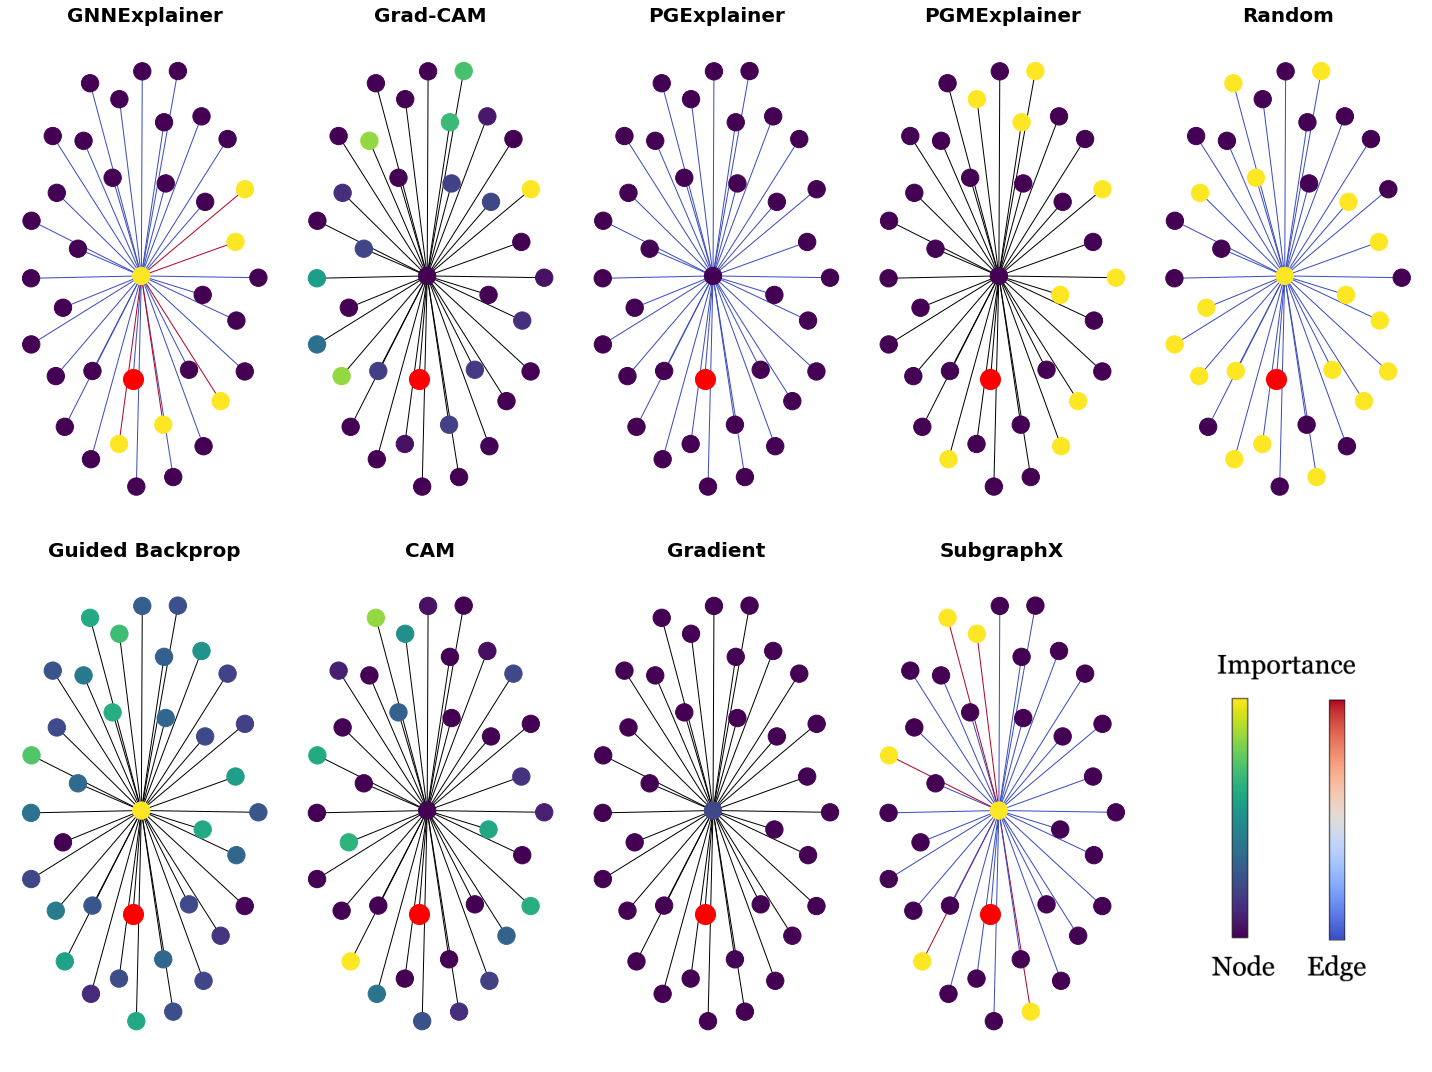

In [17]:
node_idx, gt_exp = choose_node(data, label=0, split='test', seed=5) # choose a random promoter from test set
print(node_idx)
visualize_all_explanations(data=data, label=0, node_idx=node_idx, n_hops=2)

# PROMOTER (LABEL=1)

2560
E = gnnex
E = gcam
E = pgex
E = pgmex


  0%|                                    | 1/1000000 [00:00<77:37:34,  3.58it/s]


E = rand
E = gbp
E = cam
E = grad
E = subx


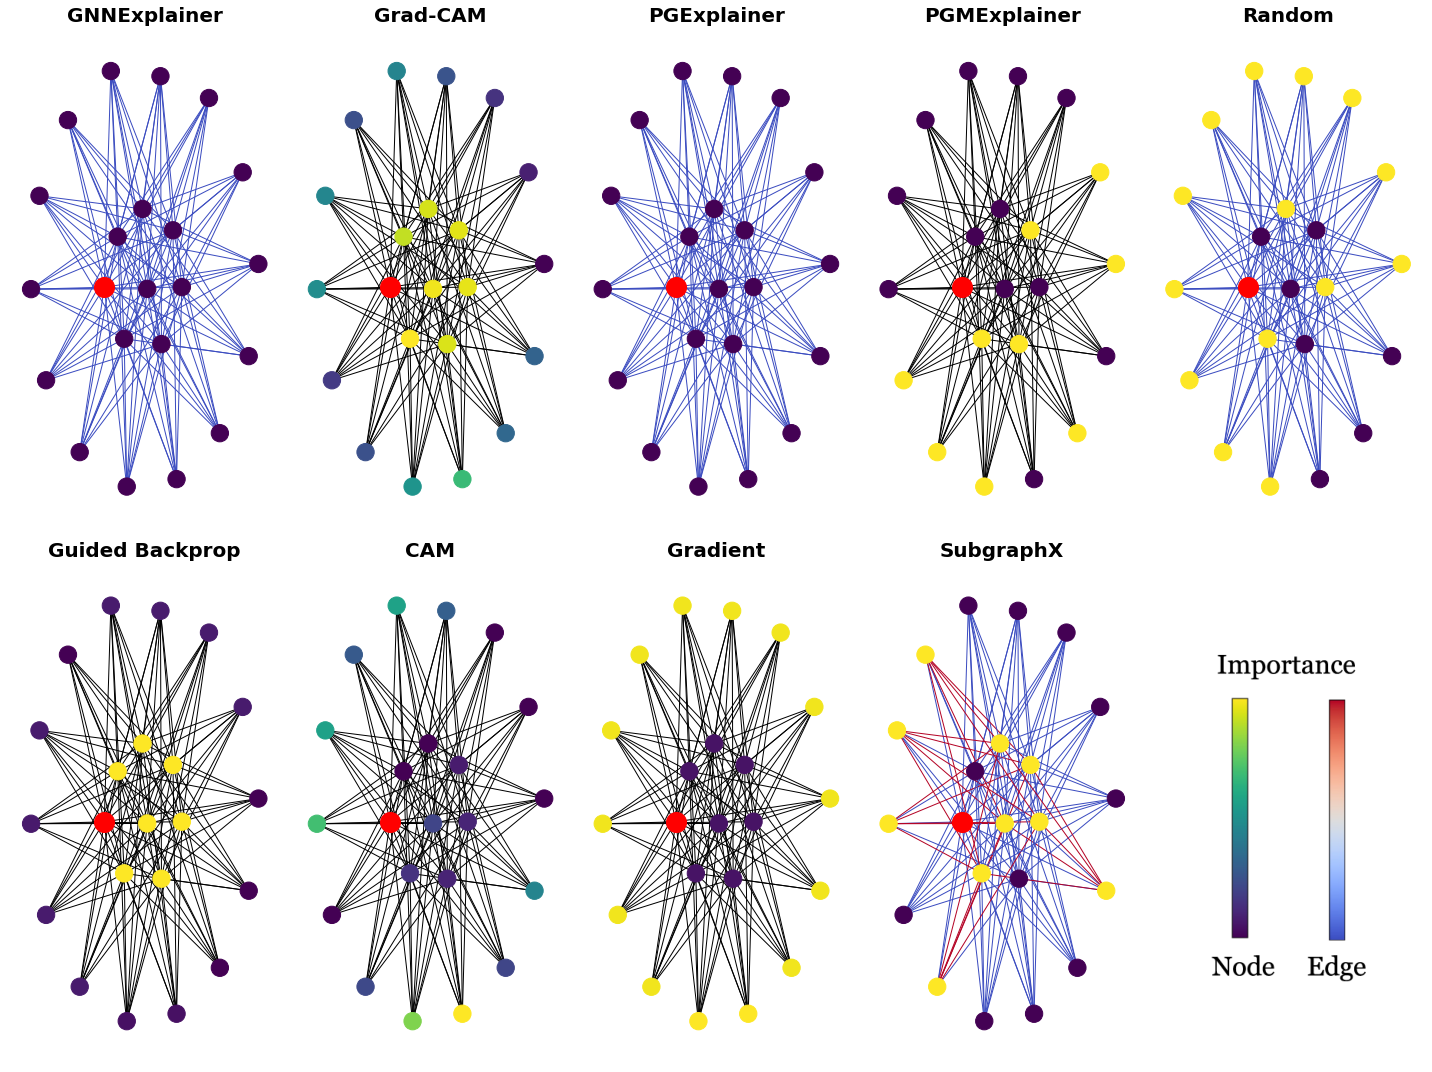

In [18]:
node_idx, gt_exp = choose_node(data, label=1, split='test', seed=5) # choose a random promoter from test set
print(node_idx)
visualize_all_explanations(data=data, label=1, node_idx=node_idx, n_hops=2)